In [1]:
from PIL import Image
import numpy as np
import pickle
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from pandas import DataFrame
from tqdm import tqdm
from IPython.display import display

c:\users\sasha\desktop\thesis\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def display_metrics(true_labels, predicted_labels, labels):
    print("Accuracy:", accuracy_score(true_labels, predicted_labels))
    print("\nConfusion matrix")
    display(DataFrame(confusion_matrix(true_labels, predicted_labels),
                      index=["Actual " + label for label in labels], columns=["Predicted " + label for label in labels]))
    print("\nPrecision, recall, F-score, support")
    display(DataFrame(np.array(precision_recall_fscore_support(true_labels, predicted_labels)),
            index=("precision", "recall", "F-score", "support"), columns=labels))

# Final model

The resulting classifier is a linear SVM classifier with input vectors of size 4096 taken from the penultimate layer of VGG-19 network, these vectors are expected to represent the photo of a car. This model performed the best out of the models that have been tried.

To classify an image we must first propagate it through the VGG-19 network to extract features and then apply the SVM classifier. These two steps are incapsulated in the following class that loads the required weights for a pretrained VGG-19 model and an SVM classifier.

In [3]:
class CarClassifier():
    _base_model = VGG19(weights='imagenet')
    _feature_model = Model(inputs=_base_model.input, outputs=_base_model.layers[-2].output)
    _SVM_clf = joblib.load('svm_vgg_19.pkl')

    def preprocess_image(self, img):
        x = np.array(img.resize((224,224))).astype(np.float32)
        x = np.expand_dims(x, axis=0)
        return preprocess_input(x, mode='tf')
    
    def predict(self, img):
        extracted_features = CarClassifier._feature_model.predict(self.preprocess_image(img))
        return CarClassifier._SVM_clf.predict(extracted_features)[0]

In [4]:
car_classifier = CarClassifier()

Now we'll test the trained classifier on the test dataset, which was unused before.

Note the usage of the classifier object. Its input must be a color image loaded with PIL.

In [5]:
with open("test.p", "rb") as test_pickle:
    test_images, test_labels = pickle.load(test_pickle)

In [6]:
predicted_labels = []
for img in tqdm(test_images):
    predicted_labels.append(car_classifier.predict(Image.open(img)))

100%|████████████████████████████████████████████████████████████████████████████████| 815/815 [13:17<00:00,  1.02it/s]


Let's look at the metrics.

In [7]:
display_metrics(test_labels, predicted_labels, ("Good Cars", "Damaged Cars"))

Accuracy: 0.9730061349693252

Confusion matrix


,Predicted Good Cars,Predicted Damaged Cars
Actual Good Cars,389,15
Actual Damaged Cars,7,404



Precision, recall, F-score, support


,Good Cars,Damaged Cars
precision,0.982323,0.964200
recall,0.962871,0.982968
F-score,0.972500,0.973494
support,404.000000,411.000000


These values are quite satisfactory and are consistent with results on the training and validation datasets.

In [8]:
def translate_prediction(prediction):
    if prediction == 0:
        return "good"
    else:
        return "damaged"

Let's take a look at some erroneous predictions.

In [9]:
erroneous_images = []
for i in range(len(test_labels)):
    if test_labels[i] != predicted_labels[i]:
        erroneous_images.append(test_images[i])
        print(test_images[i], "true:", translate_prediction(test_labels[i]))

C:\Users\Sasha\Desktop\broken cars\datasets\good_cars\good_5008.jpg true: good
C:\Users\Sasha\Desktop\broken cars\datasets\good_cars\good_6928.jpg true: good
C:\Users\Sasha\Desktop\broken cars\datasets\good_cars\good_4405.jpg true: good
C:\Users\Sasha\Desktop\broken cars\datasets\good_cars\good_5469.jpg true: good
C:\Users\Sasha\Desktop\broken cars\datasets\good_cars\good_3926.jpg true: good
C:\Users\Sasha\Desktop\broken cars\datasets\good_cars\good_0416.jpg true: good
C:\Users\Sasha\Desktop\broken cars\datasets\damaged_cars\damaged_2207.jpg true: damaged
C:\Users\Sasha\Desktop\broken cars\datasets\good_cars\good_7896.jpg true: good
C:\Users\Sasha\Desktop\broken cars\datasets\good_cars\good_0002.jpg true: good
C:\Users\Sasha\Desktop\broken cars\datasets\good_cars\good_6533.jpg true: good
C:\Users\Sasha\Desktop\broken cars\datasets\good_cars\good_6399.jpg true: good
C:\Users\Sasha\Desktop\broken cars\datasets\good_cars\good_0968.jpg true: good
C:\Users\Sasha\Desktop\broken cars\datasets

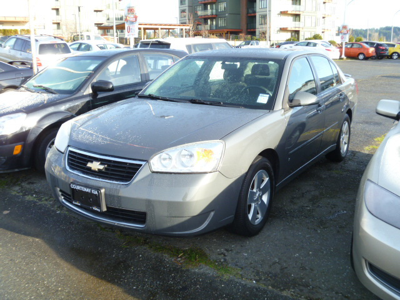

Output:  damaged


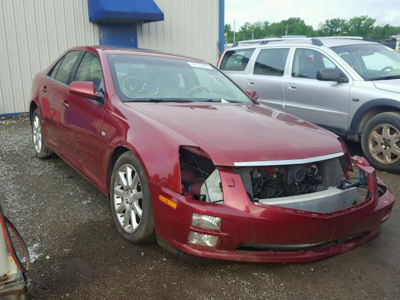

Output:  good


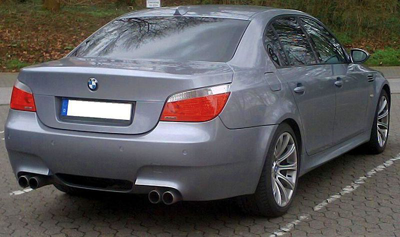

Output:  damaged


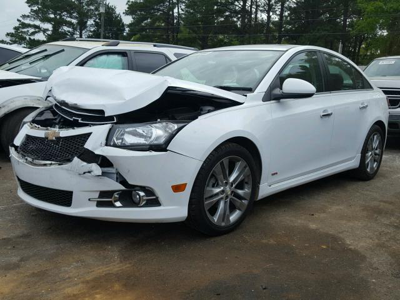

Output:  good


In [11]:
display_size = 400, 400
for img in [erroneous_images[0], erroneous_images[6], erroneous_images[7], erroneous_images[12]]:
    im = Image.open(img)
    im_copy = im.copy()
    im_copy.thumbnail(display_size)
    display(im_copy)
    print("Output: ", translate_prediction(car_classifier.predict(im)))

Finaly, several examples of predictions for the images out of the initial dataset.

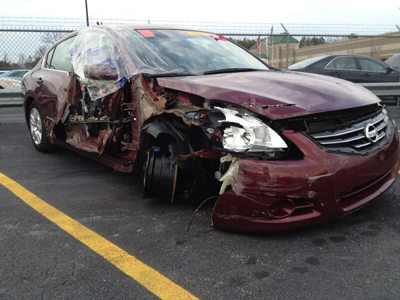

Output:  damaged


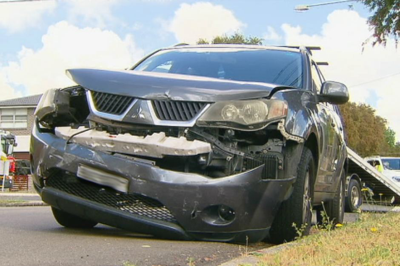

Output:  damaged


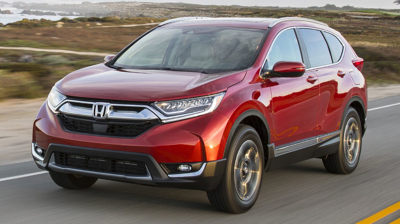

Output:  good


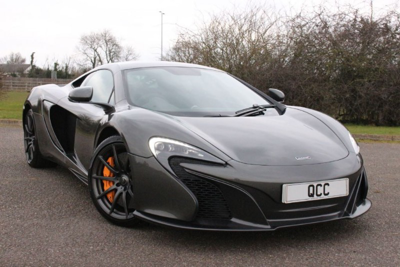

Output:  good


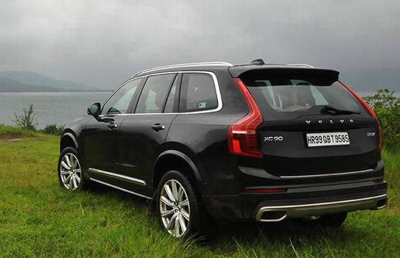

Output:  good


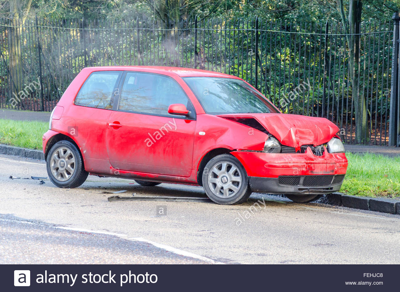

Output:  good


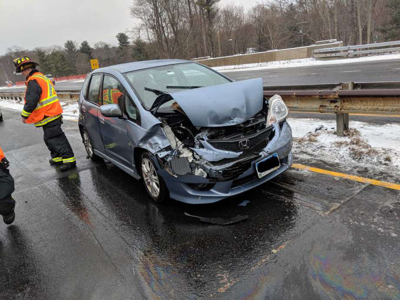

Output:  damaged


In [13]:
display_size = 400, 400
for img in ['car_1.jpg', 'car_2.jpg', 'car_3.jpg', 'car_4.jpg', 'car_5.jpg', 'car_6.jpg', 'car_7.jpg']:
    im = Image.open("extra images\\" + img)
    im_copy = im.copy()
    im_copy.thumbnail(display_size)
    display(im_copy)
    print("Output: ", translate_prediction(car_classifier.predict(im)))